In [1]:
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio
from plotly.subplots import make_subplots

In [2]:
df = pd.read_csv("einsum-data/13_50_5_complete.txt")
df.columns = df.columns.str.strip()
df["benchmark_id"] = df["file_name"].factorize()[0] + 1

# Method labeling
def method_label(row):
    if row["format"] == "dense":
        return "Dense"
    elif row["format"] == "sparse" and row["propagate"] == 0:
        return "Sparse (prop=false)"
    elif row["format"] == "sparse" and row["propagate"] == 1:
        return "Sparse (prop=true)"
    else:
        return "Other"

df["method"] = df.apply(method_label, axis=1)
df = df.sort_values(by=['benchmark_id', 'format'])

In [3]:
def plot_analysis_time():
    # Filter for sparse with propagation
    df_sparse = df[df["method"] == "Sparse (prop=true)"]
    
    # Melt the data
    df_melt = df_sparse.melt(
        id_vars=["file_name", "method", "benchmark_id"],
        value_vars=["analysis", "compilation_time", "runtime"],
        var_name="metric",
        value_name="value"
    )
    
    # Create custom color mapping
    color_map = {
        "analysis": "#2ca02c",  # Green for analysis
        "compilation_time": "#ff7f0e",  # Orange for compilation
        "runtime": "#d62728"  # Red for runtime
    }
    
    # Split benchmarks into two groups
    all_benchmarks = sorted(df_melt["benchmark_id"].unique())
    benchmarks_1 = all_benchmarks[:6]  # First 6 benchmarks
    benchmarks_2 = all_benchmarks[6:]  # Remaining benchmarks
    
    # Create subplots with 2 rows, 1 column
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Benchmarks 1-6', 'Benchmarks 7-12'),
        vertical_spacing=0.1,
        row_heights=[0.5, 0.5]
    )
    
    # Function to add bars to a subplot
    def add_benchmark_subplot(fig, benchmarks, row):
        for metric in ["analysis", "compilation_time", "runtime"]:
            metric_data = df_melt[(df_melt["metric"] == metric) & 
                                (df_melt["benchmark_id"].isin(benchmarks))]
            
            x_positions = []
            benchmark_ticks = []
            current_x = 0
            
            for benchmark_id in benchmarks:
                x_positions.extend([current_x, current_x + 1, current_x + 2])
                benchmark_ticks.append(current_x + 1)  # Center of each group
                current_x += 4  # Space between benchmark groups
            
            # Get y values in correct order
            y_values = []
            for benchmark_id in benchmarks:
                benchmark_data = metric_data[metric_data["benchmark_id"] == benchmark_id]
                if not benchmark_data.empty:
                    y_values.append(benchmark_data["value"].iloc[0])
                else:
                    y_values.append(0)
            
            fig.add_trace(go.Bar(
                x=[i + (list(color_map.keys()).index(metric)) for i in range(0, len(benchmarks) * 4, 4)],
                y=y_values,
                name=metric.replace("_", " ").title(),
                marker_color=color_map[metric],
                marker_line_width=1,
                marker_line_color='black',
                opacity=0.9,
                width=0.8,
                showlegend=(row == 1),  # Only show legend for first row
                hovertemplate=(
                    'Benchmark: %{customdata}<br>' +
                    'Metric: ' + metric.replace("_", " ").title() + '<br>' +
                    'Time: %{y:.3f}s<br>' +
                    '<extra></extra>'
                ),
                customdata=benchmarks
            ), row=row, col=1)
    
    # Add both subplots
    add_benchmark_subplot(fig, benchmarks_1, 1)
    add_benchmark_subplot(fig, benchmarks_2, 2)
    
    # Apply professional styling
    fig.update_layout(
        title=dict(
            text="Analysis Time vs Compilation Time vs Runtime (propagation=true)",
            x=0.5,
            xanchor='center',
            font=dict(size=14, color='#2c3e50'),
            y=0.95
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.07,
            xanchor="center",
            x=0.5,
            font=dict(size=11),
            itemsizing='trace',
        ),
        margin=dict(t=0, b=0, l=0, r=50),
        font=dict(size=9),
        hovermode='closest',
        width=500,
        height=600
    )
    
    # Customize x-axes
    for row, benchmarks in enumerate([benchmarks_1, benchmarks_2], 1):
        fig.update_xaxes(
            tickvals=list(range(1, len(benchmarks) * 4, 4)),
            ticktext=[str(bid) for bid in benchmarks],
            row=row, col=1,
            showgrid=True,
            gridwidth=2,
            gridcolor='#f0f0f0',
            linecolor='black',
            linewidth=2,
            tickfont=dict(size=9),
            title_text="Benchmark ID" if row == 2 else ""
        )
    
    # Customize y-axes with log scale
    fig.update_yaxes(
        type='log',
        showgrid=True,
        gridwidth=1,
        gridcolor='#f0f0f0',
        title_font=dict(size=12),
        tickfont=dict(size=11),
        row=1, col=1
    )
    
    fig.update_yaxes(
        type='log',
        showgrid=True,
        gridwidth=1,
        gridcolor='#f0f0f0',
        #linecolor='black',
        linewidth=1,
        title_font=dict(size=12),
        tickfont=dict(size=11),
        row=2, col=1
    )
    
    # Improve legend labels
    fig.update_traces(
        name='Analysis',
        selector=dict(name='Analysis')
    )
    fig.update_traces(
        name='Compilation', 
        selector=dict(name='Compilation Time')
    )
    fig.update_traces(
        name='Exeuction',
        selector=dict(name='Runtime')
    )
    fig.add_annotation(
            xref="paper",
            yref="paper",
            x=-0.1,
            y=0.5,
            text="Time (s) - Log Scale",
            showarrow=False,
            textangle=-90
    )
    fig.update_annotations(font_size=12)
    
    fig.show()
    pio.write_image(fig, "einsum_analysis_time.svg", width=500, height=600)


In [4]:
plot_analysis_time()

In [5]:
def read_csv(file_name):
    df = pd.read_csv(file_name)
    df.columns = df.columns.str.strip()
    df["benchmark_id"] = df["file_name"].factorize()[0] + 1
    df["method"] = df.apply(method_label, axis=1)
    df = df.sort_values(by=['benchmark_id', 'format'])
    return df

def filter_sparse(df):
    return df.loc[df['method'] == 'Sparse (prop=true)']

def filter_dense(df):
    return df.loc[df['method'] == 'Dense']

def get_avg(df):
    avg_cols = ["load_time", "compilation_time", "runtime", "overall_memory", "tensors-size"]

    df_avg = (
        df.groupby("file_name", as_index=False)
          .agg({
              "format": "first",
              "sparsity": "mean",
              "propagate": "first",
              "ratio_before": "mean",
              "ratio_after": "mean",
              "analysis": "mean",
              "load_time": "mean",
              "compilation_time": "mean",
              "runtime": "mean",
              "overall_memory": "mean",
              "tensors-size": "mean",
              "benchmark_id": "first",
              "method": "first"
          })
    )
    df_avg = df_avg.sort_values(by=['benchmark_id', 'format'])
    return df_avg

df_90 = read_csv("einsum-data/13_90_5_complete.txt")
df_70 = read_csv("einsum-data/13_70_5_complete.txt")
df_50 = read_csv("einsum-data/13_50_5_complete.txt")
df_30 = read_csv("einsum-data/13_30_5_complete.txt")

full_df = pd.concat([df_30, df_50, df_70, df_90])

full_sparse_df =  filter_sparse(full_df)
full_dense_df =  get_avg(filter_dense(full_df))

In [6]:
def plot_parametric_split(df):
    # First, let's extract the dense tensor sizes for normalization
    dense_sizes = {}
    for benchmark_id in df['benchmark_id'].unique():
        dense_df = df[(df['benchmark_id'] == benchmark_id) & (df['format'] == 'dense')]
        if not dense_df.empty:
            dense_sizes[benchmark_id] = dense_df.iloc[0]['tensors-size']
    
    # Create a new column for normalized tensor size
    df['normalized_tensor_size'] = df.apply(
        lambda row: row['tensors-size'] / dense_sizes[row['benchmark_id']] 
        if row['benchmark_id'] in dense_sizes else np.nan, 
        axis=1
    )
    
    # Filter for sparse data only
    sparse_df = df[df['format'] == 'sparse'].copy()
    
    # Prepare data for plotting
    plot_data = []
    for benchmark_id in sorted(sparse_df['benchmark_id'].unique()):
        for sparsity in [0.3, 0.5, 0.7, 0.9]:
            sparse_no_prop = sparse_df[
                (sparse_df['benchmark_id'] == benchmark_id) & 
                (sparse_df['sparsity'] == sparsity) & 
                (sparse_df['propagate'] == 0)
            ]
            
            sparse_with_prop = sparse_df[
                (sparse_df['benchmark_id'] == benchmark_id) & 
                (sparse_df['sparsity'] == sparsity) & 
                (sparse_df['propagate'] == 1)
            ]
            
            if not sparse_no_prop.empty and not sparse_with_prop.empty:
                plot_data.append({
                    'benchmark_id': benchmark_id,
                    'sparsity': sparsity,
                    'sparse_no_prop_size': sparse_no_prop.iloc[0]['normalized_tensor_size'],
                    'sparse_with_prop_size': sparse_with_prop.iloc[0]['normalized_tensor_size'],
                    'sparse_no_prop_absolute': sparse_no_prop.iloc[0]['tensors-size'],
                    'sparse_with_prop_absolute': sparse_with_prop.iloc[0]['tensors-size'],
                    'dense_size': dense_sizes[benchmark_id]
                })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Split benchmarks into two groups
    all_benchmarks = sorted(plot_df['benchmark_id'].unique())
    benchmarks_1 = all_benchmarks[:6]  # First 6 benchmarks
    benchmarks_2 = all_benchmarks[6:]  # Remaining benchmarks
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Benchmarks 1-6', 'Benchmarks 7-12'),
        vertical_spacing=0.1,
        row_heights=[0.5, 0.5]
    )
    fig.update_annotations(font_size=13) 
    
    # Colors and names
    sparsity_colors = {
        0.3: 'rgba(214, 39, 40, 0.8)',   # Red - 30%
        0.5: 'rgba(44, 160, 44, 0.8)',   # Green - 50% 
        0.7: 'rgba(255, 127, 14, 0.8)',  # Orange - 70%
        0.9: 'rgba(31, 119, 180, 0.8)'   # Blue - 90%
    }
    
    sparsity_names = {
        0.3: '30%',
        0.5: '50%',
        0.7: '70%', 
        0.9: '90%'
    }
    
    # Function to create plot for a subset of benchmarks
    def add_benchmark_subplot(fig, benchmarks, row):
        x_positions = []
        x_ticks = []
        benchmark_centers = []
        
        current_x = 0
        for benchmark_id in benchmarks:
            benchmark_data = plot_df[plot_df['benchmark_id'] == benchmark_id]
            
            benchmark_center = current_x + 1.5
            benchmark_centers.append(benchmark_center)
            
            for sparsity in [0.3, 0.5, 0.7, 0.9]:
                sparsity_data = benchmark_data[benchmark_data['sparsity'] == sparsity]
                if not sparsity_data.empty:
                    x_positions.append(current_x)
                    current_x += 1
            
            x_ticks.append(benchmark_center - 0.5)
            current_x += 1
        # Add bars for each sparsity level
        for sparsity in [0.3, 0.5, 0.7, 0.9]:
            sparsity_data = plot_df[(plot_df['sparsity'] == sparsity) & 
                                  (plot_df['benchmark_id'].isin(benchmarks))]
            x_pos = [x_positions[i] for i, row in enumerate(plot_df[plot_df['benchmark_id'].isin(benchmarks)].iterrows()) 
                    if row[1]['sparsity'] == sparsity]
            # Sparse without propagation
            fig.add_trace(go.Bar(
                x=x_pos,
                y=sparsity_data['sparse_no_prop_size'],
                name=f'{sparsity_names[sparsity]}' if row == 1 else '',
                marker_color=sparsity_colors[sparsity],
                marker_line_width=1.5,
                marker_line_color='darkgray',
                opacity=0.7,
                width=0.8,
                showlegend=(row == 1),
                hovertemplate=(
                    'Benchmark: %{customdata[0]}<br>' +
                    'Sparsity: %{customdata[1]}%<br>' +
                    'No Propagation: %{customdata[2]:.3f} (norm)<br>' +
                    '<extra></extra>'
                ),
                customdata=np.column_stack((
                    sparsity_data['benchmark_id'],
                    sparsity_data['sparsity'] * 100,
                    sparsity_data['sparse_no_prop_size']
                ))
            ), row=row, col=1)
            
            # Sparse with propagation
            fig.add_trace(go.Bar(
                x=x_pos,
                y=sparsity_data['sparse_with_prop_size'],
                name=f'{sparsity_names[sparsity]} (Prop)' if row == 1 else '',
                marker_color=sparsity_colors[sparsity],
                marker_line_width=1,
                marker_line_color='black',
                opacity=0.9,
                width=0.6,
                showlegend=(row == 1),
                hovertemplate=(
                    'Benchmark: %{customdata[0]}<br>' +
                    'Sparsity: %{customdata[1]}%<br>' +
                    'With Propagation: %{y:.3f} (normalized)<br>' +
                    '<extra></extra>'
                ),
                customdata=np.column_stack((
                    sparsity_data['benchmark_id'],
                    sparsity_data['sparsity'] * 100
                ))
            ), row=row, col=1)
        
        # Update x-axis for this subplot
        fig.update_xaxes(
            tickvals=x_ticks,
            ticktext=[str(bid) for bid in benchmarks],
            row=row, col=1,
            title_text="Benchmark ID" if row == 2 else ""
        )
        
        # Add horizontal line for dense baseline
        fig.add_hline(y=1, line_dash="dash", line_color="red", 
                     row=row, col=1)
    
    # Add both subplots
    add_benchmark_subplot(fig, benchmarks_1, 1)
    add_benchmark_subplot(fig, benchmarks_2, 2)

    # Customize x-axis
    fig.update_xaxes(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
    )

    # Customize y-axis
    fig.update_yaxes(
        #title_text="Normalized Tensor Size (vs Dense)",
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='black',
        #side='left',
    )
    fig.add_annotation(
        xref="paper",
        yref="paper",
        x=-0.07,
        y=0.5,
        text="Normalized Tensor Size (vs Dense)",
        showarrow=False,
        textangle=-90
    )

    fig.update_layout(
        height=700,  # Reduced height since legend is below
        width=500,
        barmode='overlay',
        showlegend=True,
        # Compact legend configuration
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.10,  # Further down
            xanchor="center",
            x=0.5,
            font=dict(size=11),  # Very small but readable
            itemsizing="constant",
            entrywidth=60,  # Very compact entries
            #traceorder="normal",
            valign="top",
        ),
        hovermode='closest',
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(t=0, b=0, l=0, r=40),
        font=dict(size=11)
    )
    
    fig.update_xaxes(
        title_font=dict(size=12),
        tickfont=dict(size=11)
    )
    fig.show()
    pio.write_image(fig, "einsum_parametric_split.svg", width=500, height=600)

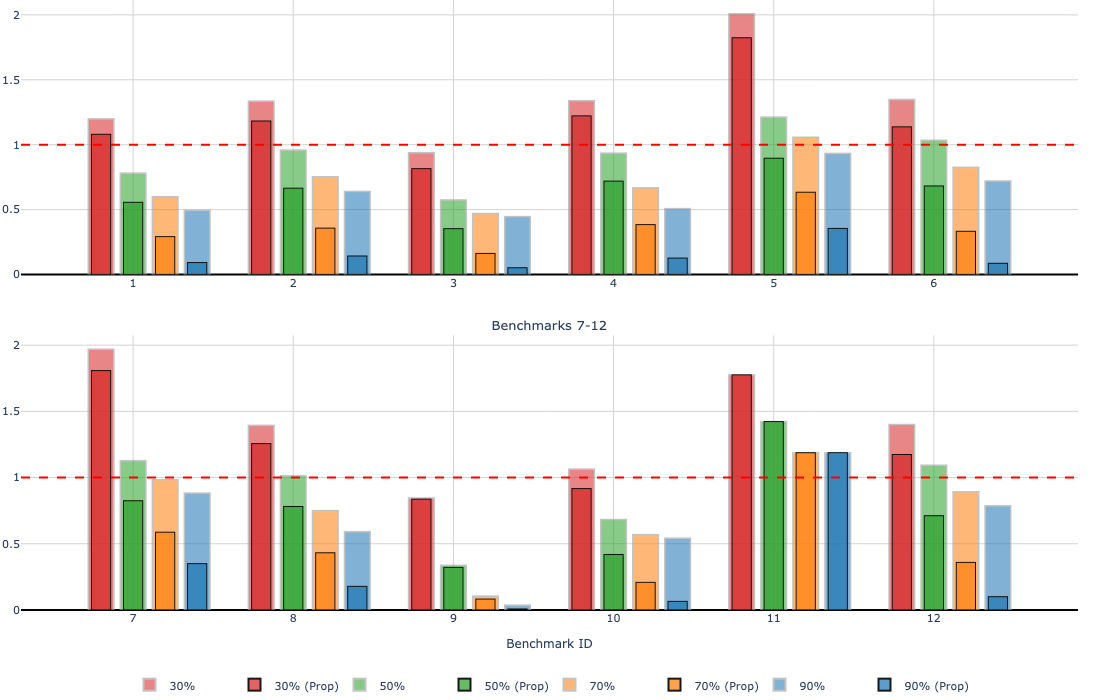

In [7]:
plot_parametric_split(full_df)

In [8]:
def plot_asymptotic(file_name):
    runtime_df = pd.read_csv(file_name)
    
    runtime_df['avg_runtime'] = runtime_df.groupby(['biggest_dim', 'scale'])['runtime'].transform('mean')
    runtime_df['avg_analysis'] = runtime_df.groupby(['biggest_dim', 'scale'])['analysis'].transform('mean')
    
    fig = go.Figure()
    
    # Add runtime curve
    fig.add_trace(go.Scatter(
        x=runtime_df['biggest_dim'],
        y=runtime_df['avg_runtime'],
        mode='lines+markers',
        name='Avg Runtime',
        yaxis='y1'
    ))
    
    # Add analysis curve
    fig.add_trace(go.Scatter(
        x=runtime_df['biggest_dim'],
        y=runtime_df['avg_analysis'],
        mode='lines+markers',
        name='Avg Analysis',
        #yaxis='y2'
    ))
    
    # Layout with two y-axes
    fig.update_layout(
        #title="Einsum Benchmark 9 - Runtime vs Analysis by Scale",
        xaxis=dict(title="Size of the Biggest Dimension",  gridcolor='lightgray',),
        yaxis=dict(title="Avg Runtime (s) - Log Scale", side="left", gridcolor='lightgray',),
        yaxis2=dict(
            title="Avg Analysis (µs)",
            overlaying="y",
            side="right",
            showgrid=False
        ),
        legend=dict(x=0.05, y=0.95),
        margin=dict(t=0, b=0, l=0, r=100),
        plot_bgcolor='white',
    )
    fig.update_yaxes(type='log')
    fig.show()
    pio.write_image(fig, "einsum9_runtime_vs_analysis.svg", width=500, height=400)

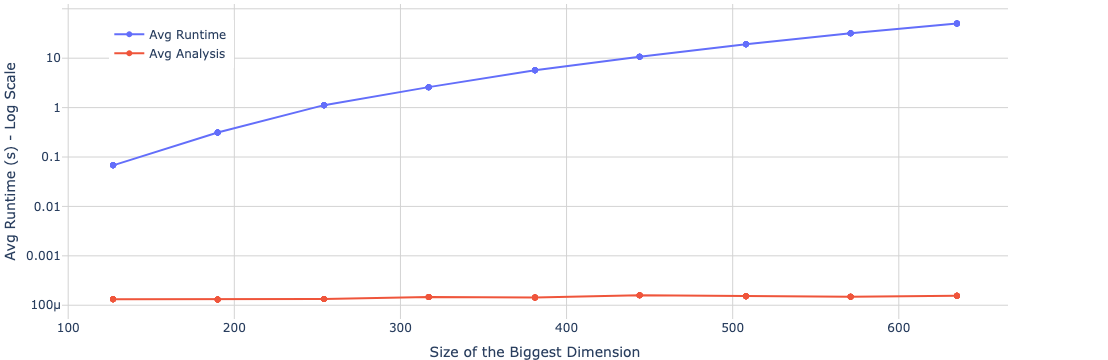

In [9]:
plot_asymptotic("einsum-data/runtime_data.csv")

In [10]:
def plot_runtime(file_name):
    df = read_csv(file_name)
    
    df['method_group'] = df['method'].apply(lambda x: 
        'Dense' if x == 'Dense' else 
        'Sparse' if 'prop=false' in x else 
        'Sparse + Prop')
    
    df["sparsity"] = df["sparsity"].apply(lambda x: int(x * 100))
    
    # Get unique sparsity values and sort them
    sparsity_values = sorted(df['sparsity'].unique())
    
    # Create the figure
    fig = go.Figure()
    color_map = {
        "analysis": "#2ca02c",  # Green for analysis
        "compilation_time": "#ff7f0e",  # Orange for compilation
        "runtime": "#d62728"  # Red for runtime
    }
    # Define colors and method order
    colors = {'Dense': '#d62728', 'Sparse': '#ff7f0e', 'Sparse + Prop': '#2ca02c'}
    method_order = ['Dense', 'Sparse', 'Sparse + Prop']
    
    # Add bars for each method
    for i, method in enumerate(method_order):
        method_data = df[df['method_group'] == method]
        
        # Sort by sparsity to ensure correct order
        method_data = method_data.sort_values('sparsity')
        
        # Calculate position with spacing between bars
        x_positions = [x + (i - 1) * 0.25 for x in range(len(sparsity_values))]
        
        fig.add_trace(go.Bar(
            x=x_positions,
            y=method_data['runtime'],  # Using runtime as Y value, change if needed
            name=method,
            #marker_color=colors[method],
            marker_line=dict(color='black', width=1),  # Thin black outline
            width=0.20,  # Bar width
            hovertemplate='Sparsity: %{customdata[0]}<br>Runtime: %{y:.4f}s<extra></extra>',
            customdata=method_data[['sparsity']].values
        ))
    
    # Update layout
    fig.update_layout(
        width=500,
        height=400,
        #title='Runtime Comparison by Sparsity and Method',
        legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.20,
                xanchor="center",
                x=0.5,
                font=dict(size=12),
                itemsizing='trace',
            ),
        xaxis=dict(
            title='% Sparsity',
            tickvals=list(range(len(sparsity_values))),
            ticktext=[f'{s}' for s in sparsity_values],
            showgrid=True,
            gridcolor='lightgray',
            linecolor='black',
            linewidth=2,
        ),
        yaxis=dict(
            title='Runtime (s)',
            showline=False,
            showgrid=True,
            gridcolor='lightgray'
        ),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1,
        plot_bgcolor='white',
        paper_bgcolor='white',
        showlegend=True,
        margin=dict(t=0, b=0, l=0, r=30),
    )
    
    fig.show()
    pio.write_image(fig, "einsum_runtime.svg", width=500, height=300)

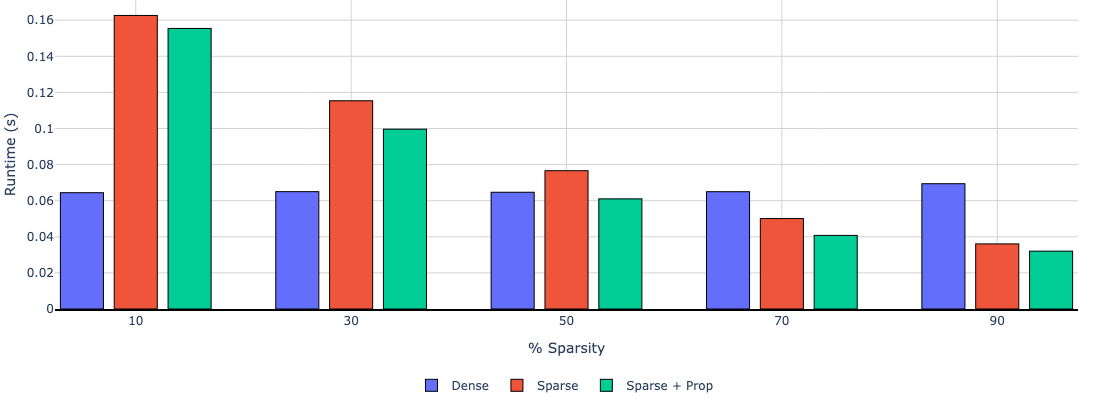

In [11]:
plot_runtime("einsum-data/str_matrix_chain_multiplication_1000.csv")